# Books' reviews analysis



Import data from the Data Analytics folder located in Drive. This data can be found here:
M. Bekheet, “Amazon Books Reviews,” 2022. [Online]. Available:
https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
Please add the downloaded .csv files to a folder called data

In [33]:
import pandas as pd
import numpy as np
import string
import re
import nltk
import gensim
import gensim.downloader as api
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from collections import Counter
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

STOP_WORDS = set(stopwords.words('english'))

stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ferni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ferni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ferni\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ferni\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


In [3]:
data_books = pd.read_csv("data/books_data.csv")
data_reviews = pd.read_csv("data/Books_rating.csv")

In [4]:
print(data_reviews.columns)
print(data_books.columns)

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')
Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount'],
      dtype='object')


In [5]:
len(data_books["Title"])

212404

In [6]:
len(data_books["categories"].unique()) #unique categories

10884

In [7]:
# get top 10 most frequent categories
n = 10
top10_categories = data_books['categories'].value_counts()[:n].index.tolist()
print(top10_categories)

["['Fiction']", "['Religion']", "['History']", "['Juvenile Fiction']", "['Biography & Autobiography']", "['Business & Economics']", "['Computers']", "['Social Science']", "['Juvenile Nonfiction']", "['Science']"]


In [8]:
#Get all the books that belong to the top 10 categories
mask_top10_titles = data_books["categories"].isin(top10_categories)
top10_titles = data_books[mask_top10_titles][["Title","categories"]]
display(top10_titles.head())
print(len(top10_titles))
print(len(top10_titles["Title"].unique())) #To check that the books titles are unique

,Title,categories
1,Dr. Seuss: American Icon,['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,['Religion']
3,Whispers of the Wicked Saints,['Fiction']
5,The Church of Christ: A Biblical Ecclesiology ...,['Religion']
8,Saint Hyacinth of Poland,['Biography & Autobiography']


75015
75015


In [9]:
#Match the titles to the categories in the reviews dataset
mask_reviews = data_reviews["Title"].isin(top10_titles["Title"])
reviews_top10 = data_reviews[mask_reviews]
display(reviews_top10.head())
print(len(reviews_top10))
print(len(reviews_top10["Title"].unique())) #check that the number of unique titles matches with the previous number

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
5,0826414346,Dr. Seuss: American Icon,NaN,A2F6NONFUDB6UK,Malvin,2/2,4.0,1127174400,One of America's greatest creative talents,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


1521077
75015


In [10]:
#Merge the two datasets to have the categories and reviews data
reviews_top10 = pd.merge(top10_titles,reviews_top10)
reviews = reviews_top10[["categories","review/score","review/time","review/text"]]
display(reviews.head())
print(len(reviews)) #to check it is the same

,categories,review/score,review/time,review/text
0,['Biography & Autobiography'],5.0,1095724800,I don't care much for Dr. Seuss but after read...
1,['Biography & Autobiography'],5.0,1078790400,"If people become the books they read and if ""t..."
2,['Biography & Autobiography'],4.0,1090713600,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
3,['Biography & Autobiography'],4.0,1107993600,Philip Nel - Dr. Seuss: American IconThis is b...
4,['Biography & Autobiography'],4.0,1127174400,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


1521077


In [11]:
#How to get only the year of the date
print(reviews_top10["review/time"][1])
datetime_object = datetime.fromtimestamp(reviews_top10["review/time"][1]).year
print(datetime_object)

1078790400
2004


In [12]:
#Check for missing values
reviews.isna().sum()

categories      0
review/score    0
review/time     0
review/text     2
dtype: int64

In [13]:
reviews = reviews.dropna(axis=0,how="any") #drop any row in the dataframe which has at least one na in its values
print(len(reviews))

1521075


In [14]:
#Check for missing values AGAIN
reviews.isna().sum()

categories      0
review/score    0
review/time     0
review/text     0
dtype: int64

In [15]:
def convert_date(x):
    return datetime.fromtimestamp(x).year

In [16]:
#Convert timestamp
reviews["review/time"] = reviews["review/time"].apply(convert_date)
display(reviews.head())
print(reviews["review/time"].unique())

,categories,review/score,review/time,review/text
0,['Biography & Autobiography'],5.0,2004,I don't care much for Dr. Seuss but after read...
1,['Biography & Autobiography'],5.0,2004,"If people become the books they read and if ""t..."
2,['Biography & Autobiography'],4.0,2004,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
3,['Biography & Autobiography'],4.0,2005,Philip Nel - Dr. Seuss: American IconThis is b...
4,['Biography & Autobiography'],4.0,2005,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


[2004 2005 2009 2008 2001 2010 2006 2000 2011 1999 2002 2003 2012 2007
 2013 1998 1997 1996 1995]


Text(0.5, 1.0, 'Number of reviews given per year of analysis')

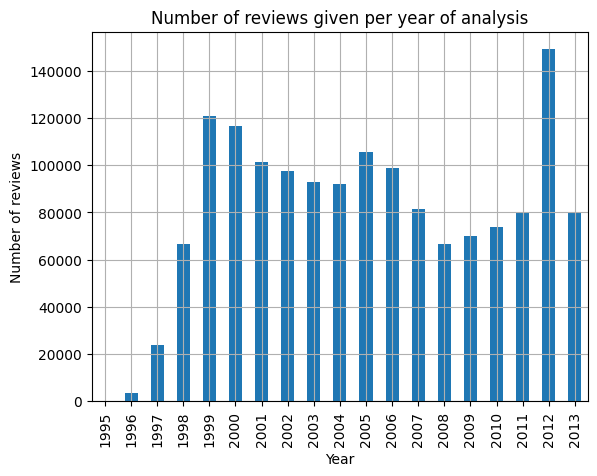

In [17]:
ax = reviews["review/time"].value_counts().sort_index().plot.bar()
ax.grid()
ax.set_xlabel("Year")
ax.set_ylabel("Number of reviews")
ax.set_title("Number of reviews given per year of analysis")

Text(0.5, 1.0, 'Number of reviews given per score')

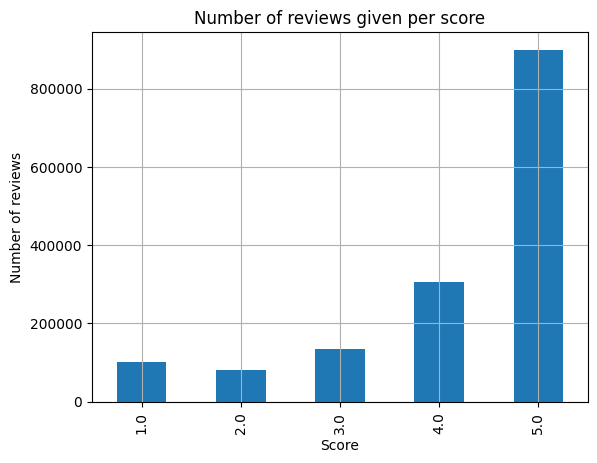

In [18]:
ax = reviews["review/score"].value_counts().sort_index().plot.bar()
ax.grid()
ax.set_xlabel("Score")
ax.set_ylabel("Number of reviews")
ax.set_title("Number of reviews given per score")

In [19]:
#Replace scores by positive or negative
reviews["review/score"] = reviews["review/score"].replace({0:'negative',1:'negative',2:'negative',3:'negative',4:'positive',5:'positive'})
display(reviews.head())
print(reviews["review/score"].unique())

,categories,review/score,review/time,review/text
0,['Biography & Autobiography'],positive,2004,I don't care much for Dr. Seuss but after read...
1,['Biography & Autobiography'],positive,2004,"If people become the books they read and if ""t..."
2,['Biography & Autobiography'],positive,2004,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
3,['Biography & Autobiography'],positive,2005,Philip Nel - Dr. Seuss: American IconThis is b...
4,['Biography & Autobiography'],positive,2005,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


['positive' 'negative']


Text(0.5, 1.0, 'Number of reviews for the positive and negative scores')

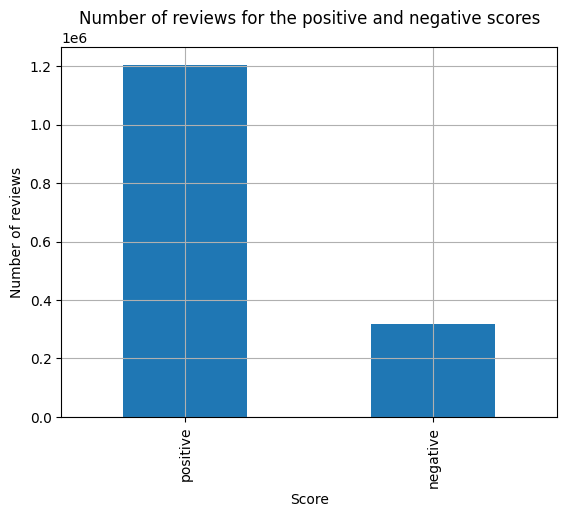

In [20]:
ax = reviews["review/score"].value_counts().plot.bar()
ax.grid()
ax.set_xlabel("Score")
ax.set_ylabel("Number of reviews")
ax.set_title("Number of reviews for the positive and negative scores")

In [21]:
#We separate them first because otherwise, they take too much RAM
#By score positive
positive = reviews.loc[reviews["review/score"]=="positive"]
display(positive.head())
print(len(positive))
print(positive["review/score"].unique()) #check that the number of unique titles matches with the previous number

,categories,review/score,review/time,review/text
0,['Biography & Autobiography'],positive,2004,I don't care much for Dr. Seuss but after read...
1,['Biography & Autobiography'],positive,2004,"If people become the books they read and if ""t..."
2,['Biography & Autobiography'],positive,2004,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
3,['Biography & Autobiography'],positive,2005,Philip Nel - Dr. Seuss: American IconThis is b...
4,['Biography & Autobiography'],positive,2005,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


1204802
['positive']


<Axes: title={'center': 'positive'}>

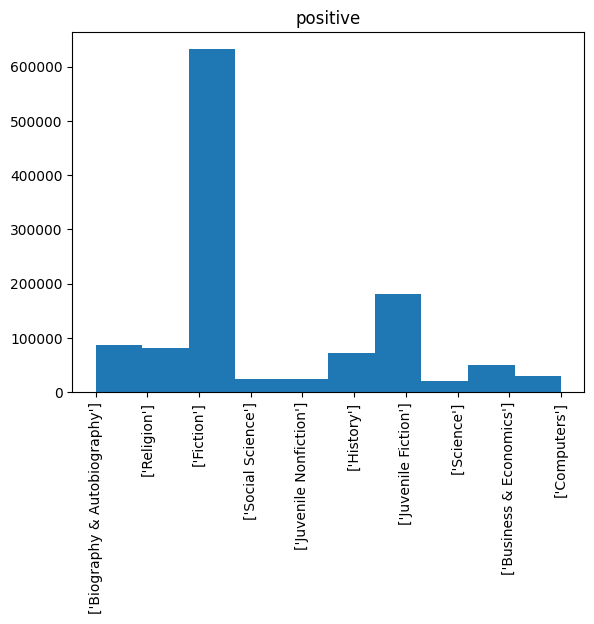

In [22]:
positive.hist(column="categories",by="review/score")

In [23]:
#We separate them first because otherwise, they take too much RAM
#By score negative
negative = reviews.loc[reviews["review/score"]=="negative"]
display(negative.head())
print(len(negative))
print(negative["review/score"].unique()) #check that the number of unique titles matches with the previous number

,categories,review/score,review/time,review/text
13,['Fiction'],negative,2005,I bought this book because I read some glowing...
15,['Fiction'],negative,2005,"This is a self-published book, and if you want..."
26,['Fiction'],negative,2005,A complete waste of time. Typographical errors...
36,['Fiction'],negative,2005,I guess you have to be a romance novel lover f...
37,['Fiction'],negative,2005,I feel I have to write to keep others from was...


316273
['negative']


<Axes: title={'center': 'negative'}>

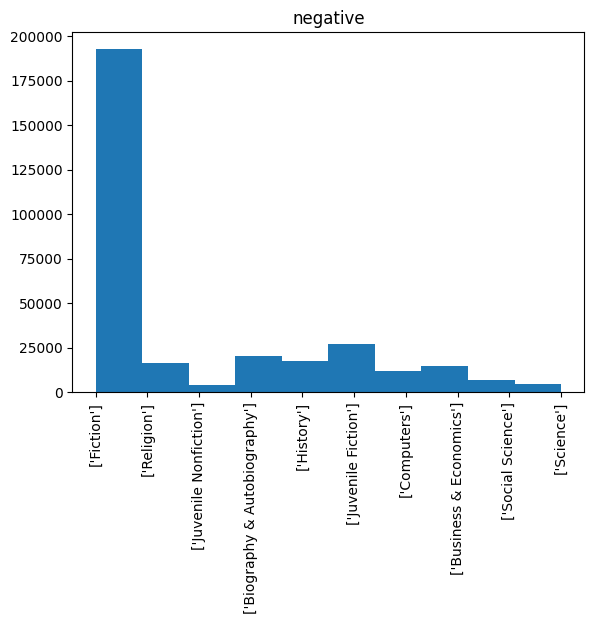

In [24]:
negative.hist(column="categories",by="review/score")

['Fiction']
631830
['Religion']
81822
['History']
72511
['Juvenile Fiction']
180673
['Biography & Autobiography']
87543
['Business & Economics']
50680
['Computers']
30684
['Social Science']
23938
['Juvenile Nonfiction']
25074
['Science']
20047


Text(0.5, 1.0, 'Number of reviews given per category for the positive class \n through the years of analysis')

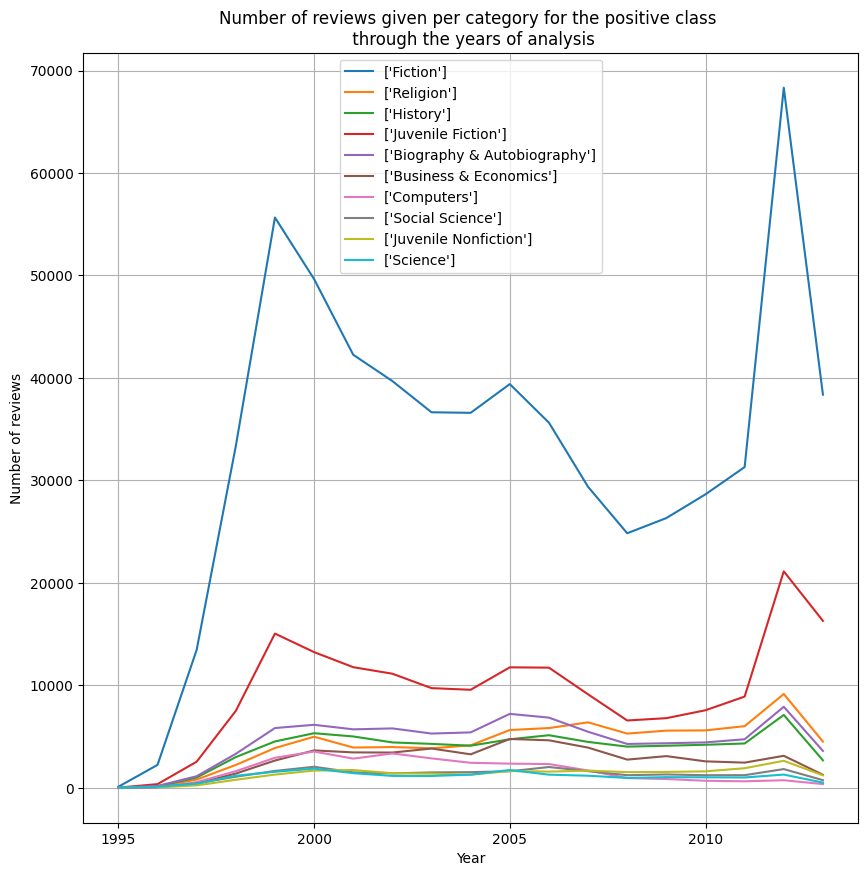

In [25]:
ax = plt.figure(figsize=(10,10))
for h in top10_categories:
  print(h)
  cat = positive.loc[positive["categories"]==h]
  print(len(cat))
  num_rev_year = cat["review/time"].value_counts().sort_index()
  ax = cat["review/time"].value_counts().sort_index().plot()
ax.legend(top10_categories)
ax.locator_params(integer=True)
ax.grid()
ax.set_xlabel("Year")
ax.set_ylabel("Number of reviews")
ax.set_title("Number of reviews given per category for the positive class \n through the years of analysis")

['Fiction']
192607
['Religion']
16213
['History']
17477
['Juvenile Fiction']
26869
['Biography & Autobiography']
20248
['Business & Economics']
14938
['Computers']
11719
['Social Science']
7134
['Juvenile Nonfiction']
4174
['Science']
4894


Text(0.5, 1.0, 'Number of reviews given per category for the negative class \n through the years of analysis')

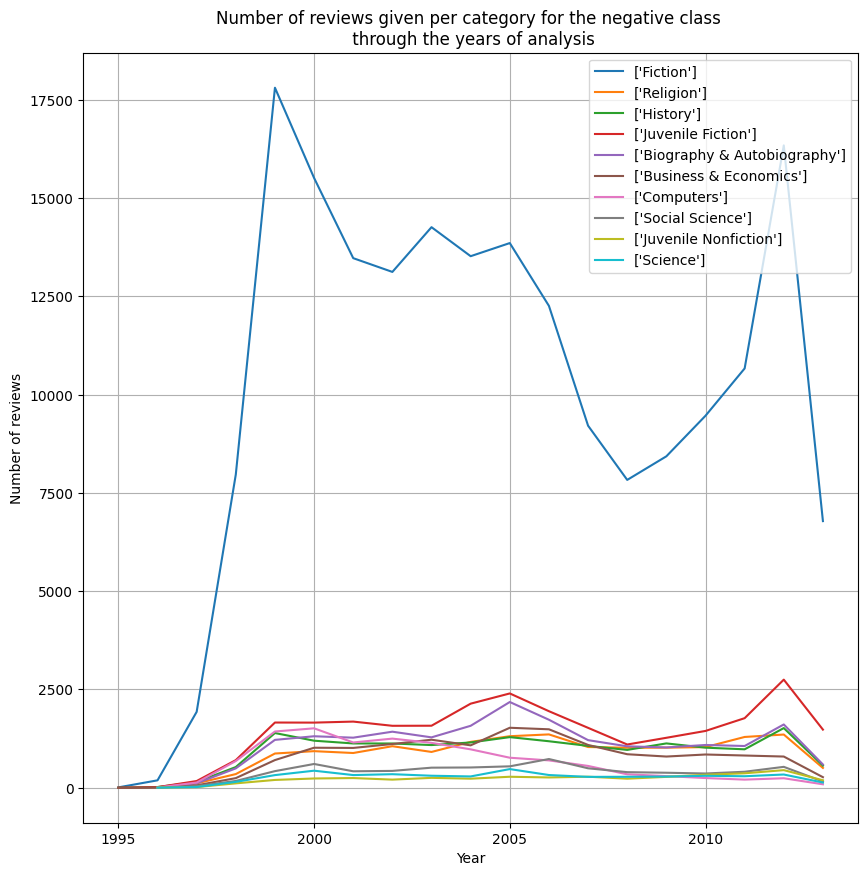

In [26]:
ax = plt.figure(figsize=(10,10))
for h in top10_categories:
  print(h)
  cat = negative.loc[negative["categories"]==h]
  print(len(cat))
  num_rev_year = cat["review/time"].value_counts().sort_index()
  ax = cat["review/time"].value_counts().sort_index().plot()
ax.legend(top10_categories)
ax.locator_params(integer=True)
ax.grid()
ax.set_xlabel("Year")
ax.set_ylabel("Number of reviews")
ax.set_title("Number of reviews given per category for the negative class \n through the years of analysis")

In [27]:
#Process the test reviews
def process_text_reviews(x):

    #Lowercase
    x = x.lower()

    #Remove numbers
    x = re.sub('[^A-Za-z0-9]+', ' ', x)

    #Remove default stop words
    text_tokens = word_tokenize(x)
    word_tokens = [
        word for word in text_tokens if not word in STOP_WORDS]

    #Lemmatizing
    #stems = [stemmer.stem(word) for word in word_tokens]

    #Tag parts of speech
    tagged = nltk.pos_tag(word_tokens)

    #Get tags
    tags = [x[1] for x in tagged]

    #Remove word if it is not a noun
    noun_list = []
    for k in range(len(tags)):
      if tags[k] == "NN":
        noun_list.append(word_tokens[k])

    #Remove words that are common to reviews but do no add to the analysis
    rem_words = ["quot","book","books","story","series","reader","read","reading","novel","anyone","something","everyone","work","way",
                 "everything","thing","part","page","time","life","use","someone","side","hand","condition","get","chapter","point",
                 "nothing","paul","anything","review"]

    top_words = [
        word for word in noun_list if not word in rem_words]

    sentence = (" ").join(top_words)

    return sentence

In [28]:
#Import pretrained word2vec model
#Reference: https://github.com/piskvorky/gensim-data
model_word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [42]:
#For the first category POSITIVE
cat_num = 0 #change this number to change the category

print(top10_categories[cat_num])
cat = positive.loc[positive["categories"]==top10_categories[cat_num]] #Separate all reviews corresponding to the category
print(len(cat))
#Sort by year
cat = cat.sort_values(by=["review/time"])
display(cat.head())
print(cat["review/time"].unique()) #Make sure its is sorted

['Fiction']
631830


,categories,review/score,review/time,review/text
533196,['Fiction'],positive,1995,"Based on the little known Mauritius campaign, ..."
597096,['Fiction'],positive,1995,"Kind of Boring at the start, But, persevere. I..."
1333301,['Fiction'],positive,1995,"For a light-hearted read, this is one of the m..."
1344949,['Fiction'],positive,1995,I can't say anything more. Just read it and ha...
906031,['Fiction'],positive,1995,"A master computer, the Oversoul, has kept watc..."


[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013]


In [43]:
#For the category find most repeated words per year
N = 70 #number of most repeated words to look for
years = cat["review/time"].unique()
top_words = []
top_words_embed = []

for k in years:
  print(k)
  rev_year = cat.loc[cat["review/time"]==k]
  print(len(rev_year))
  rev_proc = rev_year["review/text"].apply(process_text_reviews) #Apply text processing
  word_count = Counter(" ".join(rev_proc).split()).most_common(N)
  print(word_count)

  #Get only the words not their frequency
  words_vocab = [item[0] for item in word_count]
  top_words.append(words_vocab)

  #Convert each of the most repeated word into an embedding
  #Check if all words are in the vocab of the downloaded model
  words_check = [word for word in words_vocab if word in model_word2vec]
  print(len(words_check))
  #words_embed = model[words_check]
  #print(len(words_embed[0]))
  top_words_embed.append(model_word2vec[words_check])

1995
95
[('author', 10), ('smilla', 9), ('brother', 8), ('planet', 8), ('war', 8), ('doctor', 8), ('movie', 7), ('help', 6), ('boy', 6), ('century', 6), ('sense', 6), ('woman', 6), ('man', 6), ('aubrey', 5), ('kind', 5), ('science', 5), ('character', 5), ('world', 5), ('genre', 5), ('campaign', 4), ('place', 4), ('duc', 4), ('earth', 4), ('style', 4), ('building', 4), ('future', 4), ('problem', 4), ('escape', 4), ('name', 4), ('rest', 4), ('end', 4), ('fiction', 4), ('jack', 4), ('post', 4), ('pulitzer', 4), ('winner', 4), ('copy', 4), ('arrowsmith', 4), ('plunge', 4), ('struggle', 4), ('medicine', 4), ('preachy', 4), ('choice', 4), ('student', 4), ('start', 3), ('light', 3), ('child', 3), ('society', 3), ('harmony', 3), ('strength', 3), ('complexity', 3), ('greenlander', 3), ('incopenhagen', 3), ('tenant', 3), ('killer', 3), ('peter', 3), ('hoeg', 3), ('snow', 3), ('depiction', 3), ('cone', 3), ('goverment', 3), ('orwell', 3), ('passionate', 3), ('phd', 3), ('fit', 3), ('history', 3),

In [44]:
#Compute similarity between the top 70 words among themselved by their rank

len_embeds = [len(x) for x in top_words_embed]
num_elements = min(len_embeds)
print(min(len_embeds))

ec_dist = []
cos_sim = []
for k in range(len(top_words_embed)-1): #k are the years
  dist = []
  sim = []
  for h in range(num_elements):
    #Euclidean distance
    dist.append(distance.euclidean(top_words_embed[k][h],top_words_embed[k+1][h]))
    #Cosine similarity
    sim.append(distance.cosine(top_words_embed[k][h],top_words_embed[k+1][h]))
  cos_sim.append(sim)
  ec_dist.append(dist)

#Cosine similarity

62


[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012]


Text(0.5, 1.0, 'Euclidean distance between the most common words through the years')

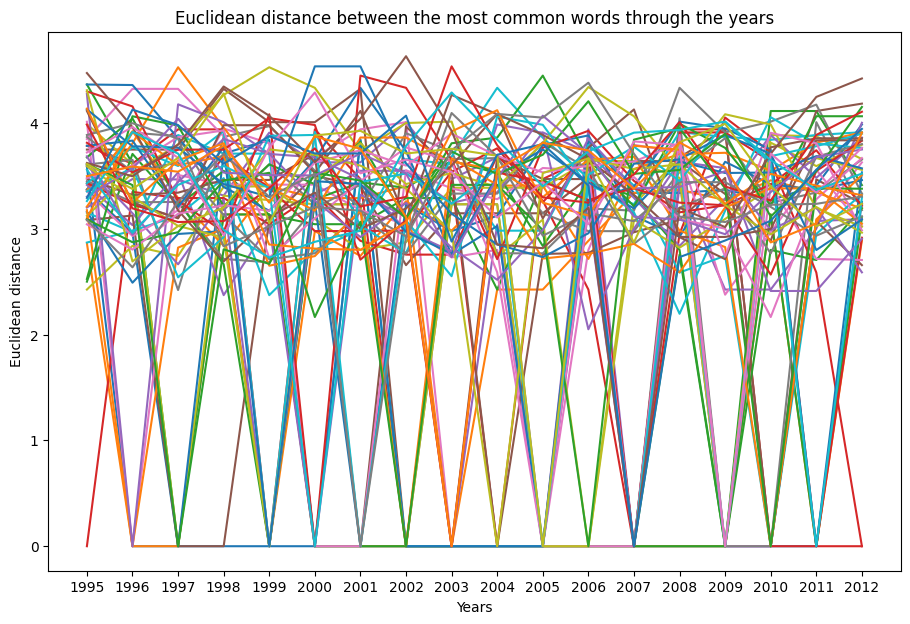

In [45]:
plt.figure(figsize=(11,7))
years = np.arange(1995,2013,1)
print(years)
for k in range(min(len_embeds)):
  plot_ec = [item[k] for item in ec_dist]
  plt.plot(years, plot_ec,label=str(k)+" word")
  plt.xlabel("Years")
  plt.ylabel("Euclidean distance")

#plt.legend()
plt.xticks(np.arange(1995, 2013, step=1))
plt.title("Euclidean distance between the most common words through the years")

[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012]


Text(0.5, 1.0, 'Cosine similarity between the most common words through the years')

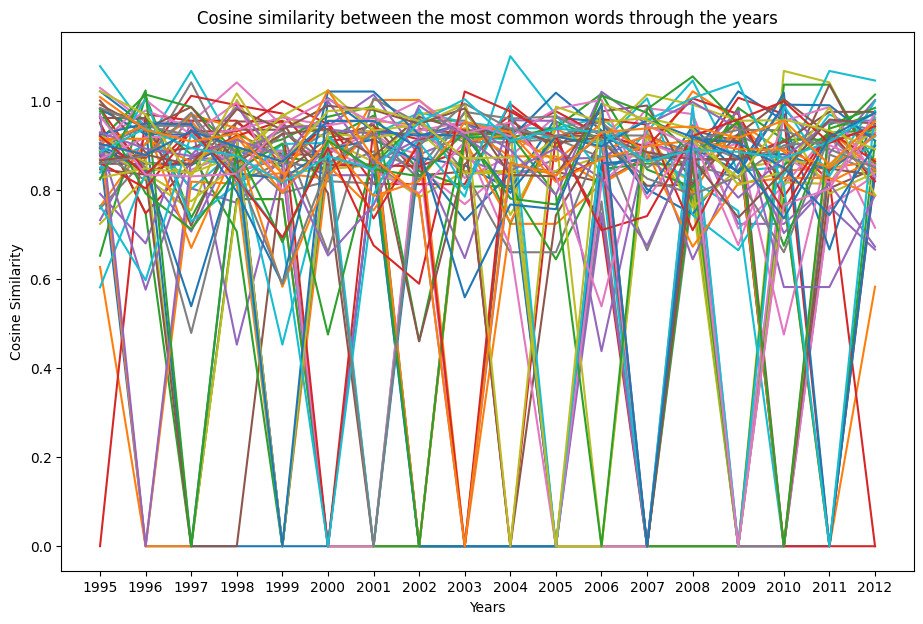

In [46]:
plt.figure(figsize=(11,7))
years = np.arange(1995,2013,1)
print(years)
for k in range(min(len_embeds)):
  plot_ec = [item[k] for item in cos_sim]
  plt.plot(years, plot_ec,label=str(k)+" word")
  plt.xlabel("Years")
  plt.ylabel("Cosine Similarity")

#plt.legend()
plt.xticks(np.arange(1995, 2013, step=1))
plt.title("Cosine similarity between the most common words through the years")

In [47]:
#The analysis will be done throughout the years, then what we call a sentence is composed by the top n word throughout the years, and so on,
#at the end we will have n sentences of length given by the number of years
print(top_words[0])
print(top_words[1])

['author', 'smilla', 'brother', 'planet', 'war', 'doctor', 'movie', 'help', 'boy', 'century', 'sense', 'woman', 'man', 'aubrey', 'kind', 'science', 'character', 'world', 'genre', 'campaign', 'place', 'duc', 'earth', 'style', 'building', 'future', 'problem', 'escape', 'name', 'rest', 'end', 'fiction', 'jack', 'post', 'pulitzer', 'winner', 'copy', 'arrowsmith', 'plunge', 'struggle', 'medicine', 'preachy', 'choice', 'student', 'start', 'light', 'child', 'society', 'harmony', 'strength', 'complexity', 'greenlander', 'incopenhagen', 'tenant', 'killer', 'peter', 'hoeg', 'snow', 'depiction', 'cone', 'goverment', 'orwell', 'passionate', 'phd', 'fit', 'history', 'look', 'yeta', 'achance', 'thesame']
['world', 'man', 'fiction', 'character', 'family', 'author', 'plot', 'love', 'war', 'history', 'end', 'mystery', 'style', 'science', 'heart', 'mind', 'woman', 'movie', 'day', 'year', 'today', 'person', 'adventure', 'death', 'clancy', 'society', 'fact', 'experience', 'fan', 'age', 'romance', 'century

In [39]:
#For some genres we do not have enough information, specially for the first years, therefore, here we pop the insufficient data
#ONLY RUN IF NECESSARY
top_words.pop(0)
print(top_words[0])

['day', 'ticket', 'home', 'factory', 'chocolate', 'com', 'boy', 'loudmouse', 'money', 'theother', 'charlie', 'control', 'theoompa', 'check', 'bar', 'adventure', 'trip', 'gloop', 'greedy', 'veruca', 'salt', 'beauregarde', 'girl', 'teavee', 'television', 'see', 'knew', 'loooooooonnnnnnggggg', 'mother', 'richard', 'wilbur', 'thoroughly', 'albeitin', 'edition', 'copy', 'amazon', 'size', 'w', 'look', 'punch', 'excitement', 'version', 'darel', 'finley', 'ghgcorp', 'dfinley', 'sorry', 'bit', 'choose', 'period', 'stevenson', 'compilation', 'timeless', 'parent', 'grandparent', 'shelf', 'h', 'b', 'gilmore', 'yeah', 'guess', 'movie', 'mention', 'material', 'browse', 'line', 'place', 'advice', 'clueless', 'plot']


In [48]:
sentences = []
separator = ' '

for k in range(70):
  sentences.append(separator.join([item[k] for item in top_words]))
  #sentences.append([item[k] for item in top_words])
print(sentences[0])
print(len(sentences))

author world world world world world world world world world world world world world world world world world love
70


In [49]:
print(sentences[-11:-1])
print(len(sentences[-11:-1]))

['cone stranger think reason home look case money adventure john son class tale fun prejudice adventure father feel period', 'goverment kind hero word detail relationship order relationship girl father murder brother line line help idea word interest tale', 'orwell sister journey detail fun night relationship reason feel feel girl adventure reason power john night help enjoy prejudice', 'passionate problem reality idea humor fun help murder father money brother experience husband relationship power power power tale attention', 'phd fantasy child fun hope order view feel fun husband idea reason relationship word murder view relationship look home', 'fit wife reason mother reason word john science reason city husband son fan daughter relationship word daughter period see', 'history jane idea reality harris reason idea journey group experience adventure feel son son line money science see child', 'look jack mother order help girl father line humor look experience husband john class girl d

In [50]:
#separate sentences into train and test

print(len(sentences))
print(sentences[-1])

X_test = sentences[-10:-1]
print(len(X_test))
print(X_test[0])
print(X_test[-1])

sentences_2 = sentences[:-10]
print(len(sentences_2))
print(sentences_2[-1])


70
thesame marriage copy girl mother detail fun father example humor science money humor view feel father look mother john
9
goverment kind hero word detail relationship order relationship girl father murder brother line line help idea word interest tale
achance course help see idea humor humor lord son view city daughter brother murder daughter country fan son death
60
cone stranger think reason home look case money adventure john son class tale fun prejudice adventure father feel period


Followed process found in: https://medium.com/@ilaslanduzgun/next-word-prediction-using-lstm-with-tensorflow-e2a8f63b613c

In [51]:
#Tokenizer process
tokenizer = Tokenizer()

#fit
tokenizer.fit_on_texts(sentences_2)

#assign length of word index
total_words = len(tokenizer.word_index) + 1

#check the tokens
tokenizer.word_index

{'author': 1,
 'world': 2,
 'man': 3,
 'character': 4,
 'movie': 5,
 'fiction': 6,
 'war': 7,
 'end': 8,
 'century': 9,
 'woman': 10,
 'sense': 11,
 'society': 12,
 'place': 13,
 'style': 14,
 'love': 15,
 'family': 16,
 'plot': 17,
 'history': 18,
 'mystery': 19,
 'day': 20,
 'heart': 21,
 'kind': 22,
 'mind': 23,
 'person': 24,
 'fact': 25,
 'romance': 26,
 'action': 27,
 'year': 28,
 'language': 29,
 'today': 30,
 'literature': 31,
 'writer': 32,
 'age': 33,
 'friend': 34,
 'jane': 35,
 'school': 36,
 'death': 37,
 'lot': 38,
 'course': 39,
 'mr': 40,
 'bit': 41,
 'job': 42,
 'home': 43,
 'tale': 44,
 'town': 45,
 'experience': 46,
 'line': 47,
 'wife': 48,
 'class': 49,
 'mother': 50,
 'science': 51,
 'adventure': 52,
 'house': 53,
 'power': 54,
 'case': 55,
 'order': 56,
 'night': 57,
 'fun': 58,
 'reason': 59,
 'help': 60,
 'feel': 61,
 'john': 62,
 'version': 63,
 'edition': 64,
 'fan': 65,
 'humor': 66,
 'father': 67,
 'look': 68,
 'girl': 69,
 'word': 70,
 'view': 71,
 'murder

In [52]:
#The whole sentence is decomposed into its elements, the first, then the first and the second, and so on, using their numeric tokenized representation

#declare ngrams
input_sequences = []
#split the sentence from '\n'
for line in sentences_2:
    #get tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)



In [54]:
sentence_token = input_sequences[17] # [1, 1561, 5, 129, 34]
sentence = []
for token in sentence_token:
    sentence.append(list((tokenizer.word_index).keys())[list((tokenizer.word_index).values()).index(token)])
print(sentence)

['author', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'love']


In [55]:
#To pad all the sequences so that they have the same length

#maximum sentence length
max_sequence_len = max([len(seq) for seq in input_sequences])
# input sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

print(input_sequences[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]


In [56]:
#X are all the sentences from element 0 to the one before the last
#y are all the last elements in all the sentences
#The test set is the last inpu sequence

X = input_sequences[:, :-1]
y = input_sequences[:, -1]

print(X[-1])
print(y[-1])

print(type(X))
print(X.shape)

[135 136  74  59  43  68  55  80  52  62 137  49  44  58 138  52  67  61]
82
<class 'numpy.ndarray'>
(1080, 18)


In [57]:
#convert one-hot-encode the y, this means putting a one in a long vector when we have the word we are analyzing, the length of the one hot encoding is
#the number of unique words
y = np.array(tf.keras.utils.to_categorical(y, num_classes=total_words))

In [58]:
#Create embedding from pretrained word2vec

def getVector(str):
  if str in model_word2vec:
    return model_word2vec[str]
  else:
    return None;

def isInModel(str):
  return str in model_word2vec


In [59]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((total_words, 300))

for word, i in tokenizer.word_index.items():
  embedding_vector = getVector(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [61]:
#create model
model = Sequential()
model.add(Embedding(total_words, 300, weights=[embedding_matrix], trainable=False))
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))
model.add(Dropout(0.1))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │        41,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,700 (162.89 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 41,700 (162.89 KB)

None


In [62]:
#compile the model
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0005),
              metrics=['accuracy'])
#fit the model
model.fit(X, y, batch_size=16, epochs=30, verbose=1)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0361 - loss: 5.9842
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0778 - loss: 5.3635
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1056 - loss: 4.8701
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1241 - loss: 4.7167
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1343 - loss: 4.4819
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1574 - loss: 4.3982
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1787 - loss: 4.1771
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1870 - loss: 4.1994
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2028 - loss: 4.1750
Epoch 10/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2296 - loss: 4.0717
Epoch 11/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2324 - loss: 3.9442
Epoch 12/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2380 - lo

In [63]:
print(X_test)
token_list = [tokenizer.texts_to_sequences([line])[0] for line in X_test]
print(token_list)

['goverment kind hero word detail relationship order relationship girl father murder brother line line help idea word interest tale', 'orwell sister journey detail fun night relationship reason feel feel girl adventure reason power john night help enjoy prejudice', 'passionate problem reality idea humor fun help murder father money brother experience husband relationship power power power tale attention', 'phd fantasy child fun hope order view feel fun husband idea reason relationship word murder view relationship look home', 'fit wife reason mother reason word john science reason city husband son fan daughter relationship word daughter period see', 'history jane idea reality harris reason idea journey group experience adventure feel son son line money science see child', 'look jack mother order help girl father line humor look experience husband john class girl daughter hero daughter copy', 'yeta earth nature hope girl attention hero fan prejudice hero look city idea girl darcy fan ad

In [64]:
#Tokenize the test set

y_test = [el[-1] for el in token_list]

X_test = [el[0:-1] for el in token_list]

print(X_test)
print(y_test)

[[22, 127, 70, 129, 73, 56, 73, 69, 67, 72, 84, 47, 47, 60, 131, 70, 121], [113, 129, 58, 57, 73, 59, 61, 61, 69, 52, 59, 54, 62, 57, 60, 78], [95, 131, 66, 58, 60, 72, 67, 80, 84, 46, 73, 54, 54, 54, 44], [115, 58, 56, 71, 61, 58, 131, 59, 73, 70, 72, 71, 73, 68], [48, 59, 50, 59, 70, 62, 51, 59, 137, 65, 124, 73, 70, 124], [18, 35, 131, 59, 131, 113, 46, 52, 61, 137, 137, 47, 80, 51], [68, 98, 50, 56, 60, 69, 67, 47, 66, 68, 46, 62, 49, 69, 124, 127, 124], [91, 79, 69, 130, 127, 65, 138, 127, 68, 131, 69, 65, 52, 72], [39, 60, 131, 66, 66, 137, 71, 124, 84, 72, 124, 116, 65, 137]]
[44, 138, 130, 43, 82, 115, 102, 51, 37]


In [65]:
# get y_test word
y_test_word = []

for k in y_test:
  for word, index in tokenizer.word_index.items():
    if index == k:
      y_test_word.append(word)
      break

print(y_test_word)


['tale', 'prejudice', 'attention', 'home', 'period', 'child', 'copy', 'science', 'death']


In [66]:
predicted = []

for k in token_list:
  #pad sequences
  pad_token = pad_sequences([k], maxlen=max_sequence_len-1, padding='pre')

  #model prediction
  predicted.append(np.argmax(model.predict(pad_token), axis=-1))

print(predicted)

output_word = []

for k in predicted:
  for word, index in tokenizer.word_index.items():
    if index == k:
      output_word.append(word)
      break

print(output_word)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[array([23], dtype=int64), array([53], dtype=int64), array([41], dtype=int64), array([29], dtype=int64), array([44], dtype=int64), array([32], dtype=int64), array([62], dtype=int64), array([47], dtype=int64), array([56], dtype=int64)]
['mind', 'house', 'bit', 'language', 'tale', 'writer', 'john', 'line', 'order']


In [68]:
#Compute the similarity between the output and predicted words 

for k in range(len(y_test_word)):
  y_test_embed = model_word2vec[y_test_word[k]]
  output_embed = model_word2vec[output_word[k]]
  print(model_word2vec.n_similarity([y_test_word[k]],[output_word[k]]))

  result_words = model_word2vec.similar_by_word(y_test_word[k])
  print(result_words)

0.06490783
[('fable', 0.7856349945068359), ('tales', 0.7368344664573669), ('story', 0.6853078603744507), ('morality_tale', 0.6596530675888062), ('timeless_tale', 0.6480308771133423), ('parable', 0.6241452693939209), ('harrowing_tale', 0.6175175309181213), ('gripping_tale', 0.6122468709945679), ('heartwarming_tale', 0.6051865816116333), ('retelling', 0.5972274541854858)]
-0.010570837
[('prejudices', 0.6801289916038513), ('bigotry', 0.614691436290741), ('bias', 0.6091493368148804), ('discrimination', 0.6066387891769409), ('racism', 0.6061381697654724), ('prejudiced', 0.60557621717453), ('stereotyping', 0.5884065628051758), ('predjudice', 0.5777552127838135), ('animus', 0.5759885311126709), ('racial_prejudice', 0.5687829852104187)]
0.100982405
[('Attention', 0.6284698247909546), ('undivided_attention', 0.5936209559440613), ('attentions', 0.5813828706741333), ('atten_tion', 0.5597048401832581), ('atttention', 0.5504755973815918), ('spotlight', 0.5051513910293579), ('notoriety', 0.498087525

In [69]:
#Euclidean distance
print(distance.euclidean(y_test_embed,output_embed))

#Cosine similarity
print(distance.cosine(y_test_embed, output_embed))


3.5537002086639404
1.0285768490542981


In [70]:
#Create RNN 
model_rnn = Sequential()
model_rnn.add(Embedding(total_words, 300, weights=[embedding_matrix], input_length=max_sequence_len-1, trainable=False))
model_rnn.add(SimpleRNN(128, return_sequences=True))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dense(256, activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(total_words, activation="softmax"))
print(model_rnn.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │        41,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,700 (162.89 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 41,700 (162.89 KB)

None


In [71]:
#compile the model
model_rnn.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=['accuracy'])
#fit the model
model_rnn.fit(X, y, batch_size=16, epochs=30, verbose=1)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0111 - loss: 4.9172
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0241 - loss: 4.7059
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0333 - loss: 4.5178
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0491 - loss: 4.3417
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0731 - loss: 4.2405
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0926 - loss: 4.0897
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1185 - loss: 3.9753
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1352 - loss: 3.8740
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1583 - loss: 3.7628
Epoch 10/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1926 - loss: 3.6587
Epoch 11/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2324 - loss: 3.5631
Epoch 12/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2407 - lo

In [72]:
predicted = []

for k in token_list:
  #pad sequences
  pad_token = pad_sequences([k], maxlen=max_sequence_len-1, padding='pre')

  #model prediction
  predicted.append(np.argmax(model_rnn.predict(pad_token), axis=-1))

print(predicted)

output_word = []

for k in predicted:
  for word, index in tokenizer.word_index.items():
    if index == k:
      output_word.append(word)
      break

print(output_word)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[array([29], dtype=int64), array([34], dtype=int64), array([29], dtype=int64), array([38], dtype=int64), array([44], dtype=int64), array([44], dtype=int64), array([55], dtype=int64), array([38], dtype=int64), array([59], dtype=int64)]
['language', 'friend', 'language', 'lot', 'tale', 'tale', 'case', 'lot', 'reason']


In [73]:
#Get similarity between output and expected words

for k in range(len(y_test_word)):
  y_test_embed = model_word2vec[y_test_word[k]]
  output_embed = model_word2vec[output_word[k]]
  print(model_word2vec.n_similarity([y_test_word[k]],[output_word[k]]))

  result_words = model_word2vec.similar_by_word(y_test_word[k])
  print(result_words)

0.074953645
[('fable', 0.7856349945068359), ('tales', 0.7368344664573669), ('story', 0.6853078603744507), ('morality_tale', 0.6596530675888062), ('timeless_tale', 0.6480308771133423), ('parable', 0.6241452693939209), ('harrowing_tale', 0.6175175309181213), ('gripping_tale', 0.6122468709945679), ('heartwarming_tale', 0.6051865816116333), ('retelling', 0.5972274541854858)]
0.0389804
[('prejudices', 0.6801289916038513), ('bigotry', 0.614691436290741), ('bias', 0.6091493368148804), ('discrimination', 0.6066387891769409), ('racism', 0.6061381697654724), ('prejudiced', 0.60557621717453), ('stereotyping', 0.5884065628051758), ('predjudice', 0.5777552127838135), ('animus', 0.5759885311126709), ('racial_prejudice', 0.5687829852104187)]
0.01734918
[('Attention', 0.6284698247909546), ('undivided_attention', 0.5936209559440613), ('attentions', 0.5813828706741333), ('atten_tion', 0.5597048401832581), ('atttention', 0.5504755973815918), ('spotlight', 0.5051513910293579), ('notoriety', 0.498087525367

In [74]:
#Euclidean distance
print(distance.euclidean(y_test_embed,output_embed))

#Cosine similarity
print(distance.cosine(y_test_embed, output_embed))


3.720137357711792
0.9857444977613384
